# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b> Описание данных </b>

Данные находятся в файле: datasets/autos.csv

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак

- Price — цена (евро)

## Описание хода работы

- Загрузить данные
- Изучить данные. Заполнить пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.

## Настройки рабочей тетради

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from random import randrange

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder

import os

In [2]:
# Настройки библиотек

pd.options.mode.chained_assignment = None  # default='warn'
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [3]:
# Путь к директории с данными

path = 'datasets/'

## Загрузка данных

In [4]:
data = pd.read_csv(os.path.join(path, 'autos.csv'))

display(data)
display(data.describe())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<b>Вывод</b>

В данных присутствуют пропуски в столбцах ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']. Т.к. пропуски сделаны в столбцах с категориальными признаками, то можно их вынести в отдельную категорию с неизвестным значением, заполнив пропуски значением 'unknown'. Восстановить данные из других строк маловероятно, т.к. у машин одной модели могут быть разные параметры.

В столбцах ['RegistrationMonth', 'RegistrationYear'] наблюдаются аномалии: год регистрации больше 2022 и месяц регистрации равный нулю. Т.к. эти столбцы также являются категориальными, такие значения можно заменить значением 'unknown'.

В данных присутствуют неинформативные признаки, а именно столбцы ['NumberOfPictures', 'DateCrawled'], потому что столбец с количеством картинок полностью заполнен нулями, а столбец с информацией о дате скачивания анкеты из базы не несёт информации о самой анкете, а значит и не может быть связан с предсказанием цены, но может повлиять на него. Такие столбцы необходимо удалить.

Столбцы ['DateCreated', 'LastSeen'] нужно разделить на отдельные категории путём выделения из даты года, месяца и дня.

Также, для экономии памяти, у столбцов с типом int64 можно изменить тип на меньший возможный тип int.

## Предобработка данных

### Анализ признаков

По порядку рассмотрим каждый столбец в данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
date_type = ['DateCrawled', 'DateCreated', 'LastSeen']
for column in date_type:
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d %H:%M:%S')

In [7]:
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 4


In [8]:
data = data.drop_duplicates()
print('Количество дубликатов в данных после очистки:', data.duplicated().sum())


Количество дубликатов в данных после очистки: 0


In [9]:
def col_desc(column):
    display(data[column].describe())
    print('Уникальные значения', data[column].unique())
    print('Количество пропусков', data[column].isna().sum())

#### Признак DateCrawled

DateCrawled — дата скачивания анкеты из базы. Т.к. мы хотим научить модель предсказывать стоимость автомобилей, то нам интересны признаки, которые связаны непосредственно с ценой автомобиля. Очевидно, что дата скачивания анкеты автомобиля из базы не может никак повлиять на его стоимость, а лишь обозначает временную метку выгрузки данных, следовательно, этот столбец нам не нужен для решения поставленной задачи и его можно удалить.

In [10]:
DateCrawled = data['DateCrawled']  # запомним этот столбец, может понадобится для анализа

data = data.drop('DateCrawled', axis=1)

#### Признак Price. Целевой признак

In [11]:
col_desc('Price')

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Уникальные значения [  480 18300  9800 ... 12395 18429 10985]
Количество пропусков 0


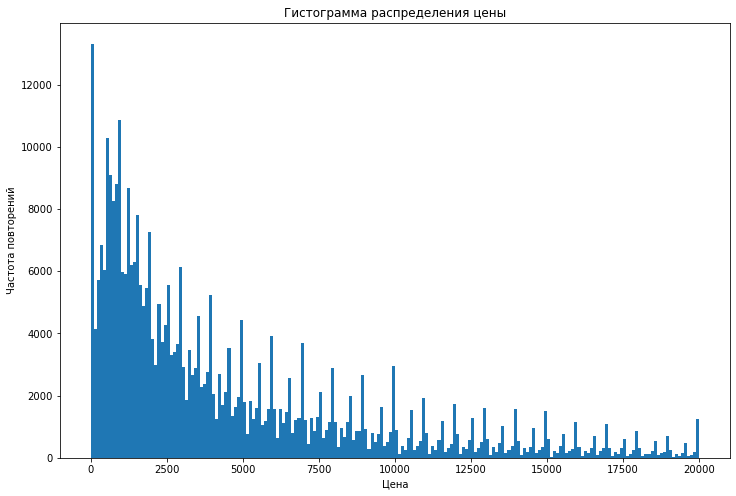

In [12]:
plt.figure(figsize=(12, 8))
plt.hist(data['Price'], bins=200)
plt.gca().set(title='Гистограмма распределения цены', ylabel='Частота повторений', xlabel='Цена')
plt.show()

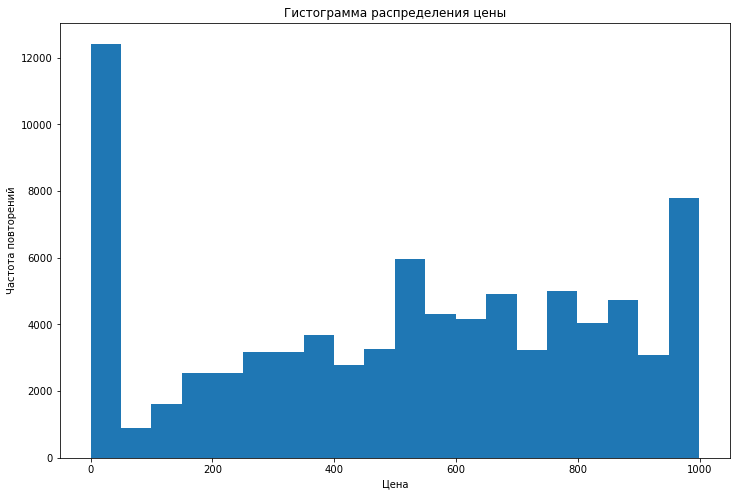

In [13]:
plt.figure(figsize=(12, 8))
plt.hist(data['Price'], bins=20, range=(0, 999))
plt.gca().set(title='Гистограмма распределения цены', ylabel='Частота повторений', xlabel='Цена')
plt.show()

In [14]:
len(data.loc[data['Price'] < 50])

12423

Гистограмма смещена влево из-за аномальных автомобилей с предельно низкой ценой, которая не может быть даже у автомобилей, которые продаются на запчасти. Причиной такой цены могут быть автомобили, владельцы которых рассматривают обмен по каким-то причинам, однако нам такие автомобили неинтересны, т.к. они также не имеют отношения к цене. Удалим автомобили с ценой ниже 50 евро.

In [15]:
data = data.loc[data['Price'] >= 50]

#### Признак VehicleType

In [16]:
col_desc('VehicleType')

count     308963
unique         8
top        sedan
freq       89169
Name: VehicleType, dtype: object

Уникальные значения [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество пропусков 32979


В столбце VehicleType наблюдаются пропущенные значения. Мы не можем заполнить эти пропуски используя данные похожих автомобилей (одной модели), т.к. в рамках одной модели возможны разные типы кузова, и нельзя заполнить пропуски значением 'other', потому что в реальности автомобиль вполне может иметь кузов из имеющихся уникальных значений ('coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'), то нам остаётся только заполнить значением 'unknown', то есть вынести такие автомобили в отдельную категорию. 

In [17]:
data['VehicleType']= data['VehicleType'].fillna('unknown')

#### Признак RegistrationYear

In [18]:
col_desc('RegistrationYear')

count    341942.000000
mean       2004.079774
std          77.070996
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Уникальные значения [1993 2011 2004 2001 2008 1995 2014 1998 2005 1910 2016 2007 2009 2002
 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000
 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1969 1971 1987 1986
 1988 1980 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1966 1975 1963 1964 1960 1958 1967 1956 3200 1000 1941 9999 8888 1500
 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019 1937 1951 1800 1959
 1953 1954 1234 8000 5300 9000 2900 6000 5900 5911 1400 5000 1950 4000
 1948 1952 8500 1932 1255 3700 3800 4800 1942 7000 1935 1933 1936 1923
 2290 1930 1001 9450 1944 2500 1943 1938 1934 1928 5555 5600 1600 1111
 2222 1039 1300 2800 1931 4500 1602 7800 1947 1927 7100 8200 1946]
Количество пропусков 0


Очевидно, что автомобили 1111 или 8200 года регистрации не могут продаваться, т.к. их не существует. Ограничим сверху годом максимального значения столбца DateCrawled, снизу - 1950 годом, т.к. более старые автомобили точно неактуальны, остальные данные удалим.

In [19]:
print('Год максимального значения столбца "DateCrawled"', DateCrawled.max().year)
print('Количество автомобилей "из будущего"', data.loc[data['RegistrationYear'] > 2016]['Price'].count())
print('Количество автомобилей зарегистрированных раньше 1950 года', data.loc[data['RegistrationYear'] < 1950]['Price'].count())

Год максимального значения столбца "DateCrawled" 2016
Количество автомобилей "из будущего" 13704
Количество автомобилей зарегистрированных раньше 1950 года 154


In [20]:
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1950)]

#### Признак Gearbox

In [21]:
col_desc('Gearbox')

count     313192
unique         2
top       manual
freq      250363
Name: Gearbox, dtype: object

Уникальные значения ['manual' 'auto' nan]
Количество пропусков 14892


Ситуация аналогична с признаком VehicleType. Заполняем пропуски значением 'unknown'

In [22]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

#### Признак Power

In [23]:
col_desc('Power')

count    328084.000000
mean        112.159331
std         185.112791
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Уникальные значения [    0   190   163    75    69   102   109   125   101   105   140   115
   131    60   136   160   231    50   118   193    99   113   218   122
   129    70   306    95    61   177   170    55   143   232   150   156
    80    82    90   155    54   185    87   180    86    84   224   235
   200   178   265    77   110   144   120   286   116   184   126   204
    88   194    64   305   197   179   250    45   313    41   165    98
   130   114   211    56   201   213    58   107    83   174   100   220
    73   192    68    66   299    74    52   147   310    71    97    65
   239   203     5   300   103    85   258   320    63    81   148    44
   145   280   260   104   188   333   186   117   141   132   234   158
    39    92    51   135    59   230    53   209    43   146    67   106
   166   276   344    72   249   237   245   111   326   279    23   138
   175    96   226    26    37   301   334   128   133   124    33   219
   241   167    94   182   196 

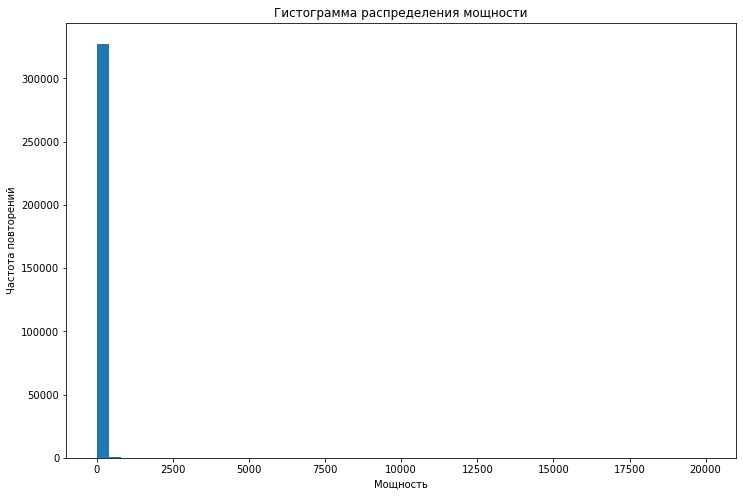

In [24]:
plt.figure(figsize=(12, 8))
plt.hist(data['Power'], bins=50)
plt.gca().set(title='Гистограмма распределения мощности', ylabel='Частота повторений', xlabel='Мощность')
plt.show()

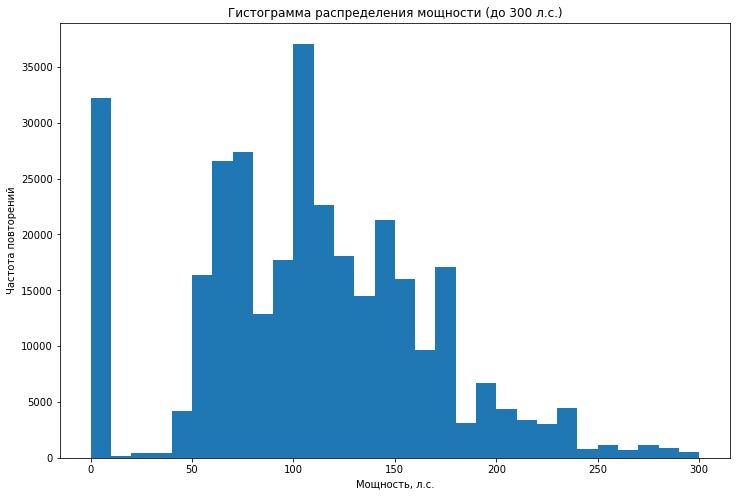

In [25]:
# Уменьшим диапазон до примерно реальных значений

plt.figure(figsize=(12, 8))
plt.hist(data['Power'], bins=30, range=(0, 300))
plt.gca().set(title='Гистограмма распределения мощности (до 300 л.с.)', ylabel='Частота повторений', xlabel='Мощность, л.с.')
plt.show()

In [26]:
print('Количество машин со слишком малой мощностью для автомобиля', data.loc[data['Power'] < 15]['Price'].count())

Количество машин со слишком малой мощностью для автомобиля 32282


In [27]:
print('Количество машин с слишком большой мощностью для автомобиля', data.loc[data['Power'] > 2000]['Price'].count())

Количество машин с слишком большой мощностью для автомобиля 101


В столбце Power присутствуют аномально большие значения мощности, слишком малые и даже нулевые. Слишком большие значения мы можем удалить, потому что их количество несущественно по сравнению с общим кол-вом данных. С малыми значениями сложнее: т.к. таких значений довольно много (почти 10% от данных), просто удалить их нельзя, поэтому заполним их значениями около медианы.

In [28]:
data = data.loc[data['Power'] <= 2000]

power_mean = data['Power'].median()

for i in data.loc[data['Power'] < 15].index:
    data.loc[i, 'Power'] = randrange(power_mean-10, power_mean+10)

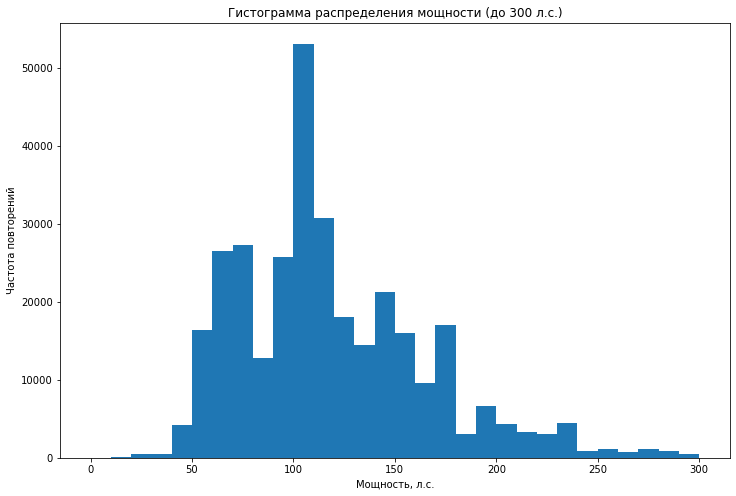

In [29]:
#Посмотрим, как изменилось распределение

plt.figure(figsize=(12, 8))
plt.hist(data['Power'], bins=30, range=(0, 300))
plt.gca().set(title='Гистограмма распределения мощности (до 300 л.с.)', ylabel='Частота повторений', xlabel='Мощность, л.с.')
plt.show()

#### Признак Model

In [30]:
col_desc('Model')

count     312742
unique       250
top         golf
freq       26628
Name: Model, dtype: object

Уникальные значения ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'one'
 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'a4' 'ka' 'a1' 'insignia' 'combo' 'focus' 'tt' 'corsa' 'a6'
 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe' 'sorento' 'v40'
 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera' 'megane' 'lupo'
 'r19' 'caddy' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo'
 'tiguan' 'sharan' '6_reihe' 'c4' 'panda' 'up' 'i_reihe' 'ceed' '5_reihe'
 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe' '6er' 'modus' 'fox' 'matiz'
 'beetle' 'c1' 'rio' 'touareg' 'logan' 'spider' 'cuore' 's_max' 'a2'
 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe' 'avensis' 'roomster' 'sl'
 'kaefer' 'santa' 'cooper' 'leon' '4_reihe' 'a5' 'sportag

Ситуация аналогична с признаком VehicleType. Заполняем пропуски значением 'unknown'

In [31]:
data['Model'] = data['Model'].fillna('unknown')

#### Признак Kilometer

In [32]:
col_desc('Kilometer')

count    327983.000000
mean     128344.380654
std       37295.688803
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Уникальные значения [150000 125000  90000  30000  70000 100000  60000   5000  20000  80000
  50000  40000  10000]
Количество пропусков 0


Столбец не требует изменений.

#### Признак RegistrationMonth

In [33]:
col_desc('RegistrationMonth')

count    327983.000000
mean          5.833933
std           3.673044
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

Уникальные значения [ 0  5  8  6  7 10 12 11  2  3  1  4  9]
Количество пропусков 0


In [34]:
data.loc[data['RegistrationMonth'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,480,unknown,1993,manual,100,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
16,300,unknown,2016,unknown,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
54,4700,wagon,2005,manual,95,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354305,3500,unknown,1995,unknown,114,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354318,400,wagon,1991,manual,111,legacy,150000,0,petrol,subaru,NaN,2016-03-15,0,24558,2016-03-19 15:49:00
354326,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,2016-03-31,0,35102,2016-04-06 13:44:44
354329,350,small,1996,unknown,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41


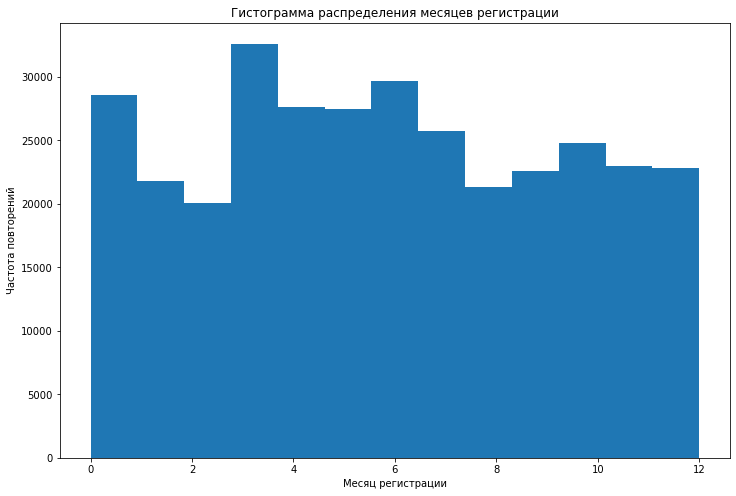

In [35]:
plt.figure(figsize=(12, 8))
plt.hist(data['RegistrationMonth'], bins=13)
plt.gca().set(title='Гистограмма распределения месяцев регистрации', ylabel='Частота повторений', xlabel='Месяц регистрации')
plt.show()

В столбце RegistrationMonth есть значения равные нулю. Очевидно, что месяца под номером 0 нет, и нам нужно обработать эти значения. Судя по гистограмме, таких значений довольно много, поэтому вряд ли это какой-то конкретный месяц. Заполнить эти нули модой тоже будет неправильно, опять же из-за большого количества таких значений - присвоение нулевым значениям моды значительно повлияет на распределение. Поэтому оставим такие значения в отдельной категории, только назовём более понятно для нас - 'unknown'

In [36]:
data.loc[data['RegistrationMonth'] == 0]['RegistrationMonth'] = 'unknown'

#### Признак FuelType

In [37]:
col_desc('FuelType')

count     304580
unique         7
top       petrol
freq      203950
Name: FuelType, dtype: object

Уникальные значения ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Количество пропусков 23403


Ситуация аналогична с признаком VehicleType. Заполняем пропуски значением 'unknown'

In [38]:
data['FuelType'] = data['FuelType'].fillna('unknown')

#### Признак Brand

In [39]:
col_desc('Brand')

count         327983
unique            40
top       volkswagen
freq           70471
Name: Brand, dtype: object

Уникальные значения ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'seat' 'honda' 'fiat' 'opel' 'mini'
 'smart' 'hyundai' 'alfa_romeo' 'subaru' 'volvo' 'mitsubishi' 'kia'
 'suzuki' 'lancia' 'citroen' 'sonstige_autos' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'chrysler' 'jaguar' 'daewoo' 'rover' 'porsche'
 'saab' 'land_rover' 'lada']
Количество пропусков 0


Столбец не требует изменений.

#### Признак NotRepaired

In [40]:
col_desc('NotRepaired')

count     269161
unique         2
top           no
freq      236503
Name: NotRepaired, dtype: object

Уникальные значения [nan 'yes' 'no']
Количество пропусков 58822


Ситуация аналогична с признаком VehicleType. Заполняем пропуски значением 'unknown'

In [41]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

#### Признак DateCreated

In [42]:
col_desc('DateCreated')

C:\Users\i\AppData\Local\Temp\ipykernel_18188\792763814.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data[column].describe())


count                  327983
unique                    108
top       2016-04-03 00:00:00
freq                    12786
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

Уникальные значения ['2016-03-24T00:00:00.000000000' '2016-03-14T00:00:00.000000000'
 '2016-03-17T00:00:00.000000000' '2016-03-31T00:00:00.000000000'
 '2016-04-04T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-03-26T00:00:00.000000000' '2016-04-07T00:00:00.000000000'
 '2016-03-15T00:00:00.000000000' '2016-03-21T00:00:00.000000000'
 '2016-03-20T00:00:00.000000000' '2016-03-23T00:00:00.000000000'
 '2016-03-27T00:00:00.000000000' '2016-03-12T00:00:00.000000000'
 '2016-03-13T00:00:00.000000000' '2016-03-18T00:00:00.000000000'
 '2016-03-07T00:00:00.000000000' '2016-03-09T00:00:00.000000000'
 '2016-03-08T00:00:00.000000000' '2016-04-03T00:00:00.000000000'
 '2016-03-29T00:00:00.000000000' '2016-03-25T00:00:00.000000000'
 '2016-03-11T00:00:00.000000000' '2016-03-28T00:00:00.000000000'
 '2016-03-30T00:00:00.000000000' '2016-03-22T00:00:00.000000000'
 '2016-02-09T00:00:00.000000000' '2016-03-05T00:00:00.000000000'
 '2016-03-10T00:00:00.000000000' '2016-04-02T00:00:00.000000000'
 '201

DateCreated - дата создания анкеты. Маловероятно, что дата создания анкеты может повлиять на целевой признак - цену, поэтому этот признак для нас неинформативен.

In [43]:
data = data.drop('DateCreated', axis=1)

#### Признак NumberOfPictures

In [44]:
col_desc('NumberOfPictures')

count    327983.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Уникальные значения [0]
Количество пропусков 0


Столбец полностью состоит из нулей. Такой признак полностью неинформативен для нашей задачи.

In [45]:
data = data.drop('NumberOfPictures', axis=1)

#### Признак PostalCode

In [46]:
col_desc('PostalCode')

count    327983.000000
mean      50788.300101
std       25764.728852
min        1067.000000
25%       30457.000000
50%       49632.000000
75%       71364.000000
max       99998.000000
Name: PostalCode, dtype: float64

Уникальные значения [70435 66954 90480 ... 14053 38325 89344]
Количество пропусков 0


PostalCode — почтовый индекс владельца анкеты. Этот признак может быть информативен, т.к. указывает на географическое положение владельца анкеты, что может повлиять на целевой признак, поэтому этот столбец оставляем без изменений.

#### Признак LastSeen

In [47]:
col_desc('LastSeen')

C:\Users\i\AppData\Local\Temp\ipykernel_18188\792763814.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data[column].describe())


count                  327983
unique                 168136
top       2016-04-07 13:17:48
freq                       16
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

Уникальные значения ['2016-04-07T03:16:57.000000000' '2016-04-07T01:46:50.000000000'
 '2016-04-05T12:47:46.000000000' ... '2016-03-13T01:44:13.000000000'
 '2016-03-19T20:44:43.000000000' '2016-03-29T10:17:23.000000000']
Количество пропусков 0


LastSeen — дата последней активности пользователя. Маловероятно, что дата последней активности пользователя может повлиять на целевой признак - цену, поэтому этот признак для нас неинформативен.

In [48]:
data = data.drop('LastSeen', axis=1)

### Вывод

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327983 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              327983 non-null  int64 
 1   VehicleType        327983 non-null  object
 2   RegistrationYear   327983 non-null  int64 
 3   Gearbox            327983 non-null  object
 4   Power              327983 non-null  int64 
 5   Model              327983 non-null  object
 6   Kilometer          327983 non-null  int64 
 7   RegistrationMonth  327983 non-null  int64 
 8   FuelType           327983 non-null  object
 9   Brand              327983 non-null  object
 10  NotRepaired        327983 non-null  object
 11  PostalCode         327983 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 40.6+ MB


In [50]:
print('Удалено', round((DateCrawled.count()-data['Price'].count())/DateCrawled.count()*100, 2), 'процентов данных')

Удалено 7.44 процентов данных


<b>Вывод</b>

Обработаны все признаки, удалено 4 неинформативных признака и 7,4% данных, которые ухудшали бы обучение модели. Найдены и обработаны аномалии в столбцах 'Power', 'RegistrationMonth'. Заполнены пропуски. Удалены дубликаты.

## Подготовка выборки к обучению моделей

In [51]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
numeric = ['Price', 'Power', 'Kilometer', 'PostalCode']

for column in numeric:
    data[column] = pd.to_numeric(data[column], downcast='integer')

In [52]:
# Преобразование категориальных признаков

data_ohe = pd.get_dummies(data, drop_first=True, columns=categorical)

print(data_ohe.columns)

Index(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'PostalCode', 'VehicleType_convertible', 'VehicleType_coupe',
       'VehicleType_other', 'VehicleType_sedan',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_unknown', 'NotRepaired_yes'],
      dtype='object', length=314)


In [53]:
# Разделение выборок на обучающую, валидационную и тестовую

data_train_ohe, data_test_ohe = train_test_split(data_ohe, test_size=0.2, random_state=12345)
data_train_ohe, data_valid_ohe = train_test_split(data_train_ohe, test_size=0.25, random_state=12345)

features_train_linear = data_train_ohe.drop('Price', axis=1)
target_train_linear = data_train_ohe['Price']
feature_valid_linear = data_valid_ohe.drop('Price', axis=1)
target_valid_linear = data_valid_ohe['Price']
features_test_linear = data_test_ohe.drop('Price', axis=1)
target_test_linear = data_test_ohe['Price']

# Обработка числовых признаков

numeric.remove('Price')
scaler = StandardScaler()
scaler.fit(features_train_linear[numeric])
features_train_linear[numeric] = scaler.transform(features_train_linear[numeric])
feature_valid_linear[numeric] = scaler.transform(feature_valid_linear[numeric])
features_test_linear[numeric] = scaler.transform(features_test_linear[numeric])

obj_feat = list(data.loc[:, data.dtypes == 'object'].columns.values)
for feature in obj_feat:
    data[feature] = pd.Series(data[feature], dtype="category")

data_train, data_test = train_test_split(data, test_size=0.2, random_state=12345)
data_train, data_valid = train_test_split(data_train, test_size=0.25, random_state=12345)

features_train = data_train.drop('Price', axis=1)
target_train = data_train['Price']
feature_valid = data_valid.drop('Price', axis=1)
target_valid = data_valid['Price']
features_test = data_test.drop('Price', axis=1)
target_test = data_test['Price']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
feature_valid[numeric] = scaler.transform(feature_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

In [54]:
# Функция для нахождения RMSE моделей

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [55]:
# Очистка памяти

del data
del data_ohe
#del data_ohe_1
#del data_ohe_2
del data_train_ohe
del data_test_ohe
del data_valid_ohe

В библиотеке lightgbm будем использовать модель LGBMRegressor. При создании этой модели можно использовать разные значения параметра 'boosting_type'. Переберём их.

In [56]:
boosting_types = ['gbdt', 'dart', 'goss']

fit_time_list = []
predict_time_list = []
rmse_list = []

for value in boosting_types:
    model = LGBMRegressor(boosting_type=value, random_state=12345)
    start = time.time()
    model.fit(features_train, target_train)
    end = time.time()
    fit_time = round(end-start, 4)
    start = time.time()
    predictions = model.predict(feature_valid)
    end = time.time()
    predict_time = round(end-start, 4)
    
    fit_time_list.append(fit_time)
    predict_time_list.append(predict_time)
    rmse_list.append(rmse(predictions, target_valid))
    
    print('boosting_type=' + value)
    print('Время обучения:', fit_time)
    print('Время предсказания:', predict_time)
    print('Значение метрики RMSE:', rmse(predictions, target_valid))

boosting_type=gbdt
Время обучения: 1.0687
Время предсказания: 0.1895
Значение метрики RMSE: 1640.022462313679
boosting_type=dart
Время обучения: 3.0569
Время предсказания: 0.1667
Значение метрики RMSE: 1794.6329852172294
boosting_type=goss
Время обучения: 1.429
Время предсказания: 0.1862
Значение метрики RMSE: 1646.9317500032435


Наименьшие значения времени и RMSE у модели градиентного бустинга дерева решений, значит с ней и будем дальше работать. Переберём для неё гиперпараметры и найдём наилучшую модель.

P.S. По умолчанию: num_leaves=31, n_estimators=100

In [57]:
# Подбор парамтеров, дающих наилучшее значение контрольной метрики

best_result = 5000 
best_leaf = 0
best_est = 0
i = 0

for leaf in range(40, 71, 5):
    for est in range(100, 201, 10):
        model = LGBMRegressor(boosting_type='gbdt', num_leaves=leaf, n_estimators=est, random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(feature_valid)
        result = rmse(predictions, target_valid)
        if result < best_result:
            best_leaf = leaf
            best_est = est
            best_result = result
            
        i += 1
        print('Прогресс: ['+str(i)+'/77]')
            
print('Лучший результат метрики RMSE у модели LGBRegressor равен', best_result)
print('Значение num_leaves равно', best_leaf)
print('Значение n_estimators равно', best_est)

Прогресс: [1/77]
Прогресс: [2/77]
Прогресс: [3/77]
Прогресс: [4/77]
Прогресс: [5/77]
Прогресс: [6/77]
Прогресс: [7/77]
Прогресс: [8/77]
Прогресс: [9/77]
Прогресс: [10/77]
Прогресс: [11/77]
Прогресс: [12/77]
Прогресс: [13/77]
Прогресс: [14/77]
Прогресс: [15/77]
Прогресс: [16/77]
Прогресс: [17/77]
Прогресс: [18/77]
Прогресс: [19/77]
Прогресс: [20/77]
Прогресс: [21/77]
Прогресс: [22/77]
Прогресс: [23/77]
Прогресс: [24/77]
Прогресс: [25/77]
Прогресс: [26/77]
Прогресс: [27/77]
Прогресс: [28/77]
Прогресс: [29/77]
Прогресс: [30/77]
Прогресс: [31/77]
Прогресс: [32/77]
Прогресс: [33/77]
Прогресс: [34/77]
Прогресс: [35/77]
Прогресс: [36/77]
Прогресс: [37/77]
Прогресс: [38/77]
Прогресс: [39/77]
Прогресс: [40/77]
Прогресс: [41/77]
Прогресс: [42/77]
Прогресс: [43/77]
Прогресс: [44/77]
Прогресс: [45/77]
Прогресс: [46/77]
Прогресс: [47/77]
Прогресс: [48/77]
Прогресс: [49/77]
Прогресс: [50/77]
Прогресс: [51/77]
Прогресс: [52/77]
Прогресс: [53/77]
Прогресс: [54/77]
Прогресс: [55/77]
Прогресс: [56/77]
П

In [58]:
# Измерение времени работы наилучшей модели

model = LGBMRegressor(boosting_type='gbdt', num_leaves=best_leaf, n_estimators=best_est, random_state=12345)
start = time.time()
model.fit(features_train, target_train)
end = time.time()
fit_time = round(end-start, 4)
start = time.time()
predictions = model.predict(feature_valid)
end = time.time()
predict_time = round(end-start, 4)

print('Время обучения:', fit_time)
print('Время предсказания:', predict_time)
print('Значение метрики RMSE:', rmse(predictions, target_valid))

fit_time_list.append(fit_time)
predict_time_list.append(predict_time)
rmse_list.append(rmse(predictions, target_valid))
boosting_types.append('gbdt_best')

Время обучения: 2.2152
Время предсказания: 0.308
Значение метрики RMSE: 1563.173728775846


Для сравнения также рассмотрим контрольные значения уже знакомой модели линейной регрессии.

In [59]:
# Линейная регрессия

model = LinearRegression()
start = time.time()
model.fit(features_train_linear, target_train_linear)
end = time.time()
fit_time = round(end-start, 4)
start = time.time()
predictions = model.predict(feature_valid_linear)
end = time.time()
predict_time = round(end-start, 4)
    
print('Значение метрики RMSE у модели линейной регрессии', rmse(predictions, target_valid_linear))
print('Время обучения', fit_time)
print('Время предсказания', predict_time)

fit_time_list.append(fit_time)
predict_time_list.append(predict_time)
rmse_list.append(rmse(predictions, target_valid_linear))
boosting_types.append('linear regression')

Значение метрики RMSE у модели линейной регрессии 2715.024080382376
Время обучения 3.039
Время предсказания 0.1131


## Анализ моделей

По ходу рассмотрения все контрольные значения мы заносили в списки, теперь для анализа их можно внести в таблицу.

In [60]:
model_analys = pd.DataFrame()
model_analys['model'] = boosting_types
model_analys['RMSE'] = rmse_list
model_analys['fit_time'] = fit_time_list
model_analys['predict_time'] = predict_time_list

display(model_analys.sort_values('RMSE'))

,model,RMSE,fit_time,predict_time
3,gbdt_best,1563.173729,2.2152,0.3080
0,gbdt,1640.022462,1.0687,0.1895
2,goss,1646.931750,1.4290,0.1862
1,dart,1794.632985,3.0569,0.1667
4,linear regression,2715.024080,3.0390,0.1131


<b>Анализ</b>

Как видим, наилучшая модель по метрике RMSE это модель gbdt с подобранными гиперпараметрами, но она отстаёт по времени обучения почти в 3.5 раза и почти в 2 раза по времени предсказания от ближайшей по метрике RMSE. Хуже всего по RMSE показала себя модель линейной регрессии, но она имеет наименьшее время предсказания.    

Все модели подходят под условие, что значение метрики RMSE должно быть меньше 2500, поэтому выбираем модель с наименьшим значением времени обучения и времени предсказания. Это модель LGBMRegressor с параметром boosting_type='gbdt'. Проверяем на тестовой выборке.

In [61]:
model = LGBMRegressor(boosting_type='gbdt', random_state=12345)
start = time.time()
model.fit(features_train, target_train)
end = time.time()
fit_time = round(end-start, 4)
start = time.time()
predictions = model.predict(features_test)
end = time.time()
predict_time = round(end-start, 4)

print('Время обучения:', fit_time)
print('Время предсказания:', predict_time)
print('Значение метрики RMSE:', rmse(predictions, target_test))

Время обучения: 1.007
Время предсказания: 0.191
Значение метрики RMSE: 1649.4694385194798


<b>Вывод</b>

Данные обработаны и подготовлены для обучения моделей. Обучены несколько моделей из библиотеки LightGBM, подобраны гиперпараметры для одной из них, также обучена модель линейной регрессии. На основе контрольных значений, а именно: метрики RMSE, времени обучения и времени предсказания, выбрана наилучшая модель. Итоговая модель построена, значение метрики RMSE удовлетворяет условию RMSE<2500.